In [1]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import random

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(19)

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
csv_data = pd.read_csv('/content/drive/MyDrive/data/pmi-data.csv')

print(csv_data.describe())
csv_data.head()

                 id       gender          age  hypertension  heart_disease  \
count   3566.000000  3566.000000  3566.000000   3566.000000    3566.000000   
mean   36785.750701     1.394279    48.853898      0.125070       0.063937   
std    21239.999608     0.489337    18.874375      0.330845       0.244675   
min       67.000000     0.000000    10.000000      0.000000       0.000000   
25%    18042.750000     1.000000    34.000000      0.000000       0.000000   
50%    37448.500000     1.000000    50.000000      0.000000       0.000000   
75%    54984.250000     2.000000    63.000000      0.000000       0.000000   
max    72915.000000     2.000000    82.000000      1.000000       1.000000   

       ever_married    work_type  Residence_type  avg_glucose_level  \
count   3566.000000  3566.000000     3566.000000        3566.000000   
mean       0.759955     3.424846        0.491307         108.982011   
std        0.427170     0.894640        0.499995          48.292204   
min        0.

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,split
0,9046,2,67.0,0,1,1,4,0,228.69,36.6,1,1,test
1,51676,1,61.0,0,0,1,3,1,202.21,29.1,2,1,train
2,31112,2,80.0,0,1,1,4,1,105.92,32.5,2,1,train
3,60182,1,49.0,0,0,1,4,0,171.23,34.4,0,1,train
4,1665,1,79.0,1,0,1,3,1,174.12,24.0,2,1,train


In [5]:
X_train = csv_data[csv_data['split'] == 'train'].drop(columns=['id', 'split', 'stroke'])
y_train = csv_data[csv_data['split'] == 'train']['stroke']
X_test = csv_data[csv_data['split'] == 'test'].drop(columns=['id', 'split', 'stroke'])
y_test = csv_data[csv_data['split'] == 'test']['stroke']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=17)

print(X_train.describe())
print(y_train.describe())
print(X_test.describe())
print(y_test.describe())
print(X_val.describe())
print(y_val.describe())

# X_train.head()
# y_train.head()
# X_test.head()
# y_test.head()
# X_val.head()
# y_val.head()

train_num_positives = y_train.sum()
train_num_negatives = y_train.shape[0] - train_num_positives
train_ratio = train_num_negatives / train_num_positives

print(f'Train Dataset Imbalance: {train_num_positives}, {train_num_negatives}, Ratio: {train_ratio}')

            gender          age  hypertension  heart_disease  ever_married  \
count  2139.000000  2139.000000   2139.000000    2139.000000   2139.000000   
mean      1.391772    48.820009      0.131837       0.067789      0.767181   
std       0.489217    18.932919      0.338393       0.251442      0.422727   
min       0.000000    10.000000      0.000000       0.000000      0.000000   
25%       1.000000    34.000000      0.000000       0.000000      1.000000   
50%       1.000000    50.000000      0.000000       0.000000      1.000000   
75%       2.000000    63.000000      0.000000       0.000000      1.000000   
max       2.000000    82.000000      1.000000       1.000000      1.000000   

         work_type  Residence_type  avg_glucose_level          bmi  \
count  2139.000000     2139.000000        2139.000000  2139.000000   
mean      3.437120        0.487611         108.984175    30.175596   
std       0.885992        0.499963          48.771008     7.238643   
min       0.00000

Why splitting the dataset into a train and validation set is good practice:
- it prevents overfitting, if we train and evaluate models on same data they might simply memorize the outputs
- by providing the model with data it has never seen during the training phase, we can ensure that it is able to generalize
- the validation data should be large enough to give a clear evaluation of the model's ability to generalize, but not too much, as that would leave insufficient data for training


In [6]:
class StrokeDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.values, dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)
    self.length = self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return self.length

train_dataset = StrokeDataset(X_train, y_train)
test_dataset = StrokeDataset(X_test, y_test)
val_dataset = StrokeDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(NeuralNetwork, self).__init__()

    if (hidden_sizes is None) or len(hidden_sizes) == 0:
      raise ValueError('hidden_sizes is None or empty')

    layers = []
    layers.append(nn.Linear(input_size, hidden_sizes[0]))
    for idx in range(1, len(hidden_sizes)):
      layers.append(nn.ReLU())
      layers.append(nn.Linear(hidden_sizes[idx - 1], hidden_sizes[idx]))

    layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    # layers.append(nn.Sigmoid())

    self.layers = nn.ModuleList(layers)

  def forward(self, X):
    for layer in self.layers:
      X = layer(X)
    return X

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model0 = NeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[32, 64, 16], output_size=1)
model0.to(device)

for param in model0.parameters():
  print(param)
print()

model1 = NeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[32, 64, 16], output_size=1)
model1.to(device)

for param in model1.parameters():
  print(param)
print()

model2 = NeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[32, 64, 16], output_size=1)
model2.to(device)

for param in model2.parameters():
  print(param)
print()

Parameter containing:
tensor([[ 0.2964, -0.1898,  0.2403,  0.1026, -0.1795, -0.2408, -0.0875, -0.3057,
          0.2216,  0.2922],
        [-0.1594, -0.1299, -0.2997, -0.2599, -0.0076, -0.2619,  0.0518, -0.3120,
          0.1449, -0.0440],
        [-0.1414, -0.0963,  0.0323, -0.1450,  0.1033, -0.1555,  0.2678,  0.0252,
         -0.2442, -0.0610],
        [ 0.2611,  0.2838,  0.2781,  0.3048, -0.0837, -0.1751, -0.2696, -0.0199,
         -0.1823,  0.2628],
        [-0.0194,  0.0092, -0.1790, -0.1915, -0.3139, -0.0382,  0.0992, -0.2106,
         -0.0004,  0.1323],
        [ 0.0663, -0.0115,  0.1466, -0.2395, -0.2909, -0.2192, -0.0452, -0.0368,
          0.0634, -0.0426],
        [ 0.0540,  0.2632,  0.0656,  0.0674, -0.0917, -0.1622,  0.1768,  0.1525,
          0.1337,  0.0798],
        [-0.1967, -0.0512,  0.1485,  0.1589, -0.1563,  0.0530, -0.0995, -0.1397,
         -0.2953, -0.1406],
        [-0.1222, -0.2272,  0.0590,  0.2849,  0.0936,  0.1227,  0.0266,  0.2047,
         -0.0268,  0.0283

In [9]:
def train(model, sigmoid_threshold, loss_function, epochs, learning_rate):

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_epoch_losses = []
  train_epoch_accuracies = []

  val_epoch_losses = []
  val_epoch_accuracies = []

  val_predictions = []
  val_labels = []

  for epoch in range(epochs):
    model.train()

    train_current_epoch_loss = 0.0
    train_current_epoch_correct_predictions = 0
    train_current_epoch_total_predictions = 0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = loss_function(outputs.view(-1), y_batch)
      loss.backward()
      optimizer.step()

      train_current_epoch_loss += loss.item()

      predictions = (torch.sigmoid(outputs) > sigmoid_threshold).float()
      train_current_epoch_correct_predictions += (predictions.squeeze(dim=1) == y_batch).sum().item()
      train_current_epoch_total_predictions += y_batch.size(0)

    train_current_epoch_avg_loss = train_current_epoch_loss / len(train_loader)
    train_current_epoch_accuracy = train_current_epoch_correct_predictions / train_current_epoch_total_predictions

    train_epoch_losses.append(train_current_epoch_avg_loss)
    train_epoch_accuracies.append(train_current_epoch_accuracy)

    print(f'Training, Epoch {epoch + 1}/{epochs}, Loss: {train_current_epoch_avg_loss}, Accuracy: {train_current_epoch_accuracy}')

    model.eval()

    val_current_epoch_loss = 0.0
    val_current_epoch_correct_predictions = 0
    val_current_epoch_total_predictions = 0

    val_predictions = []
    val_labels = []

    with torch.no_grad():
      for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = loss_function(outputs.view(-1), y_batch)

        val_current_epoch_loss += loss.item()

        predictions = (torch.sigmoid(outputs) > sigmoid_threshold).float()
        val_current_epoch_correct_predictions += (predictions.squeeze(dim=1) == y_batch).sum().item()
        val_current_epoch_total_predictions += y_batch.size(0)

        val_predictions.extend(predictions.cpu().numpy())
        val_labels.extend(y_batch.cpu().numpy())

      val_current_epoch_avg_loss = val_current_epoch_loss / len(val_loader)
      val_current_epoch_accuracy = val_current_epoch_correct_predictions / val_current_epoch_total_predictions

      val_epoch_losses.append(val_current_epoch_avg_loss)
      val_epoch_accuracies.append(val_current_epoch_accuracy)

      print(f'Validation, Epoch {epoch + 1}/{epochs}, Loss: {val_current_epoch_avg_loss}, Accuracy: {val_current_epoch_accuracy}')

  return train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies, val_predictions, val_labels

In [10]:
def plot_train_results(train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies, val_predictions, val_labels):

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(train_epoch_losses, label='Training Loss', color='blue')
  plt.plot(val_epoch_losses, label='Validation Loss', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_epoch_accuracies, label='Training Accuracy', color='blue')
  plt.plot(val_epoch_accuracies, label='Validation Accuracy', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracies')
  plt.legend()

  plt.tight_layout()
  plt.show()

  val_predictions = np.array(val_predictions).reshape(-1)
  val_labels = np.array(val_labels).reshape(-1)

  conf_matrix = confusion_matrix(val_labels, val_predictions)

  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])

  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')

  plt.show()

  precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary', zero_division=0)

  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1 Score: {f1_score}')

  return precision, recall, f1_score

In [11]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=0.7, gamma=2.0, reduction='mean'):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
    self.reduction = reduction

  def forward(self, inputs, targets):
    probabilities = torch.sigmoid(inputs)
    pt = probabilities * targets + (1.0 - probabilities) * (1 - targets)
    alpha_t = self.alpha * targets + (1.0 - self.alpha) * (1 - targets)
    EPSILON = 1e-7
    focal_loss = -alpha_t * ((1.0 - pt) ** self.gamma) * torch.log(pt + EPSILON)
    if self.reduction == 'mean':
      return torch.mean(focal_loss)
    elif self.reduction == 'sum':
      return torch.sum(focal_loss)
    else:
      return focal_loss

In [12]:
# model0.load_state_dict(torch.load('/content/drive/MyDrive/data/model0.pth'))
# model1.load_state_dict(torch.load('/content/drive/MyDrive/data/model1.pth'))
# model2.load_state_dict(torch.load('/content/drive/MyDrive/data/model2.pth'))

Training, Epoch 1/32, Loss: 0.27088964445626035, Accuracy: 0.9453015427769986
Validation, Epoch 1/32, Loss: 0.23694397260745367, Accuracy: 0.9495091164095372
Training, Epoch 2/32, Loss: 0.24271471031448422, Accuracy: 0.9453015427769986
Validation, Epoch 2/32, Loss: 0.197723055879275, Accuracy: 0.9495091164095372
Training, Epoch 3/32, Loss: 0.22203676643617012, Accuracy: 0.9453015427769986
Validation, Epoch 3/32, Loss: 0.17879314968983331, Accuracy: 0.9495091164095372
Training, Epoch 4/32, Loss: 0.21690724527134614, Accuracy: 0.9453015427769986
Validation, Epoch 4/32, Loss: 0.18085266246149936, Accuracy: 0.9495091164095372
Training, Epoch 5/32, Loss: 0.20866861062891343, Accuracy: 0.9453015427769986
Validation, Epoch 5/32, Loss: 0.16789874884610376, Accuracy: 0.9495091164095372
Training, Epoch 6/32, Loss: 0.20401965498047717, Accuracy: 0.9453015427769986
Validation, Epoch 6/32, Loss: 0.16737669302771488, Accuracy: 0.9495091164095372
Training, Epoch 7/32, Loss: 0.20664573088288307, Accur

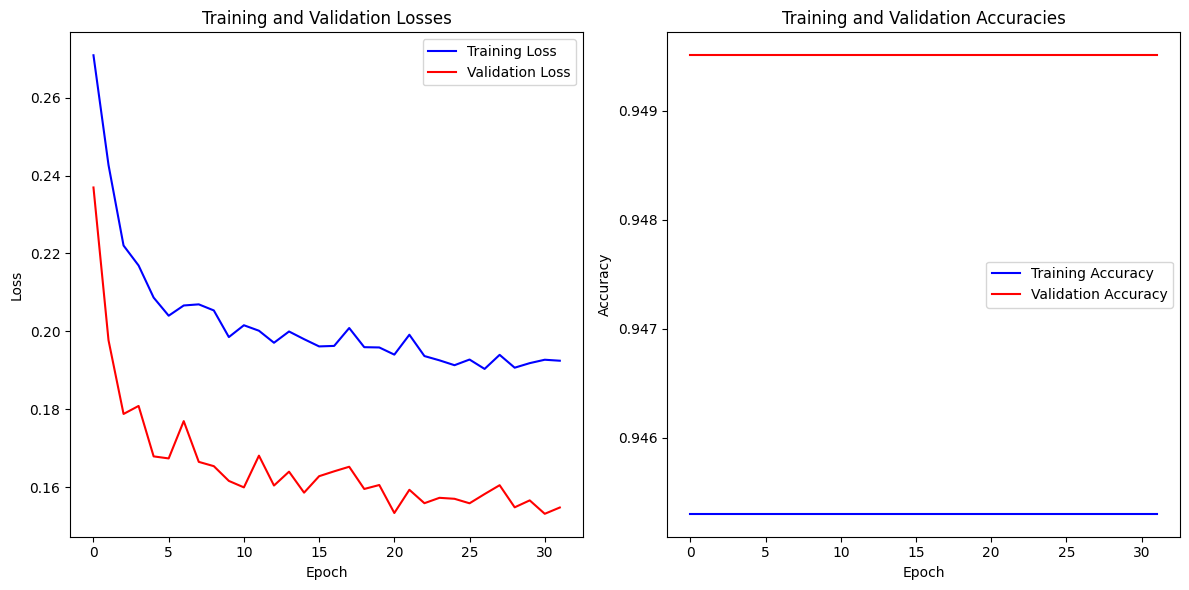

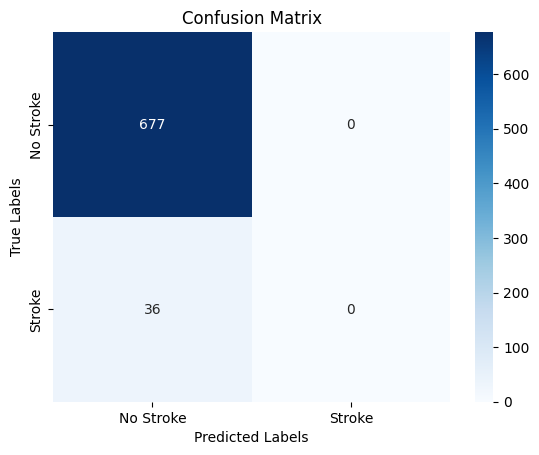

Precision: 0.0
Recall: 0.0
F1 Score: 0.0


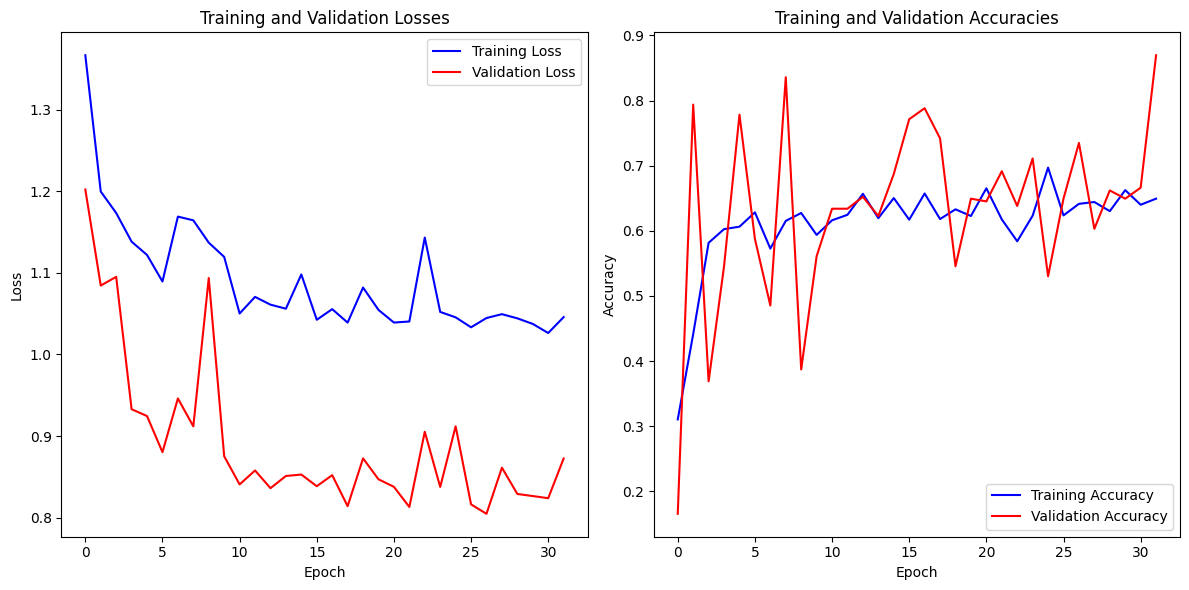

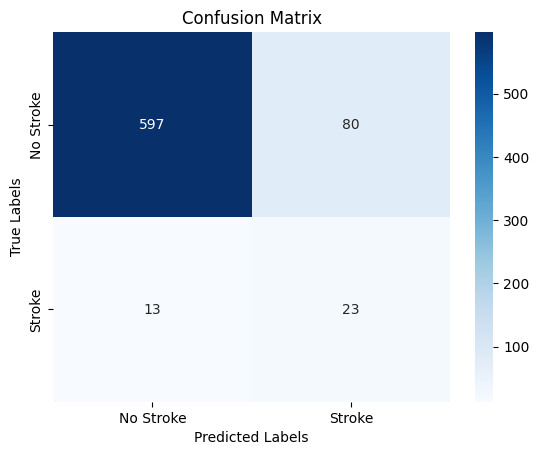

Precision: 0.22330097087378642
Recall: 0.6388888888888888
F1 Score: 0.33093525179856115


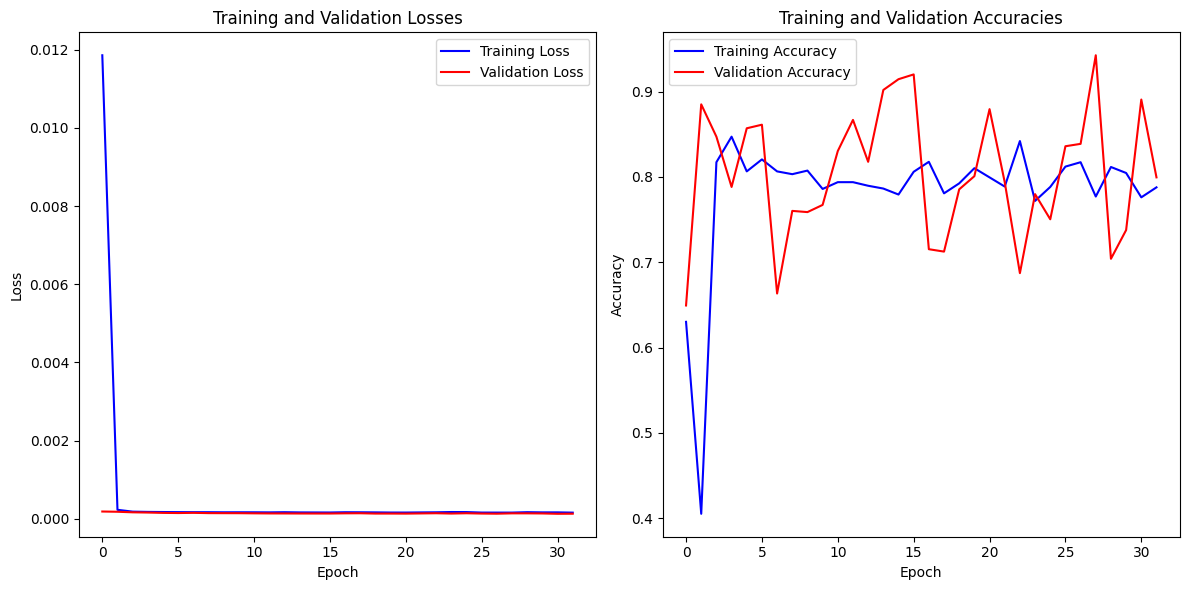

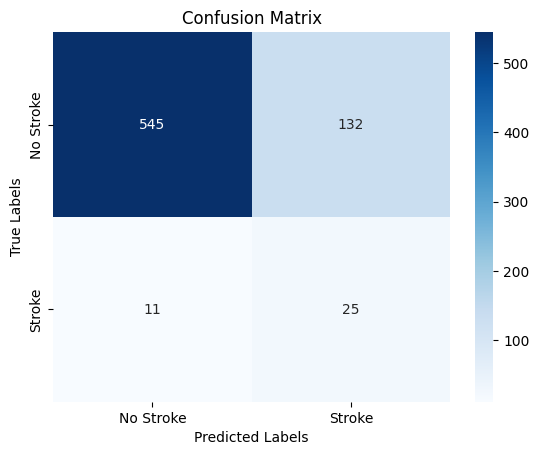

Precision: 0.1592356687898089
Recall: 0.6944444444444444
F1 Score: 0.25906735751295334


(0.1592356687898089, 0.6944444444444444, 0.25906735751295334)

In [13]:
train_epoch_losses0, train_epoch_accuracies0, val_epoch_losses0, val_epoch_accuracies0, val_predictions0, val_labels0 = train(model0, 0.5, nn.BCEWithLogitsLoss(), 32, 0.001)
train_epoch_losses1, train_epoch_accuracies1, val_epoch_losses1, val_epoch_accuracies1, val_predictions1, val_labels1 = train(model1, 0.5, nn.BCEWithLogitsLoss(pos_weight=torch.tensor([train_ratio]).to(device)), 32, 0.001)
train_epoch_losses2, train_epoch_accuracies2, val_epoch_losses2, val_epoch_accuracies2, val_predictions2, val_labels2 = train(model2, 0.5, FocalLoss(alpha=0.9, gamma=9.0), 32, 0.001)

plot_train_results(train_epoch_losses0, train_epoch_accuracies0, val_epoch_losses0, val_epoch_accuracies0, val_predictions0, val_labels0)
plot_train_results(train_epoch_losses1, train_epoch_accuracies1, val_epoch_losses1, val_epoch_accuracies1, val_predictions1, val_labels1)
plot_train_results(train_epoch_losses2, train_epoch_accuracies2, val_epoch_losses2, val_epoch_accuracies2, val_predictions2, val_labels2)

In [14]:
# torch.save(model0.state_dict(), '/content/drive/MyDrive/data/model0.pth')
# torch.save(model1.state_dict(), '/content/drive/MyDrive/data/model1.pth')
# torch.save(model2.state_dict(), '/content/drive/MyDrive/data/model2.pth')

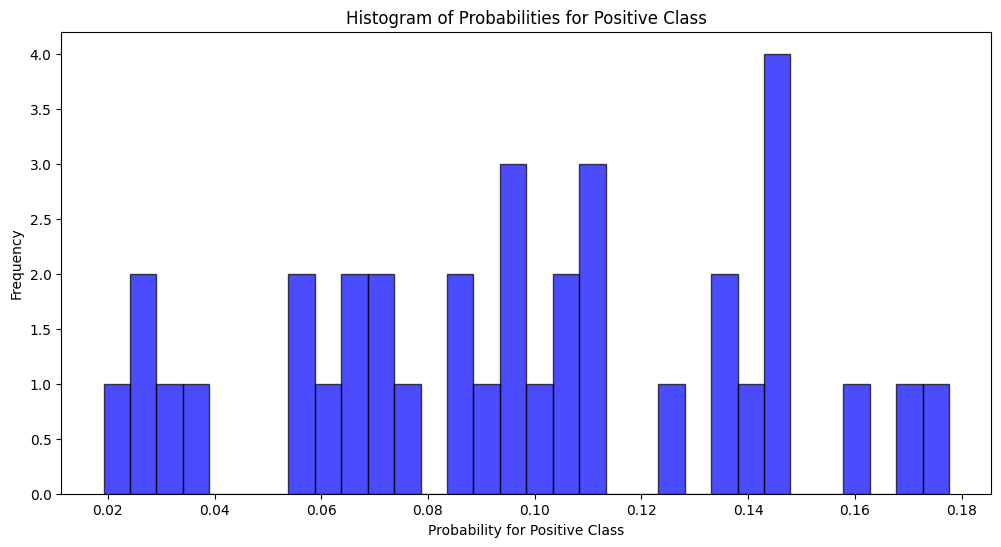

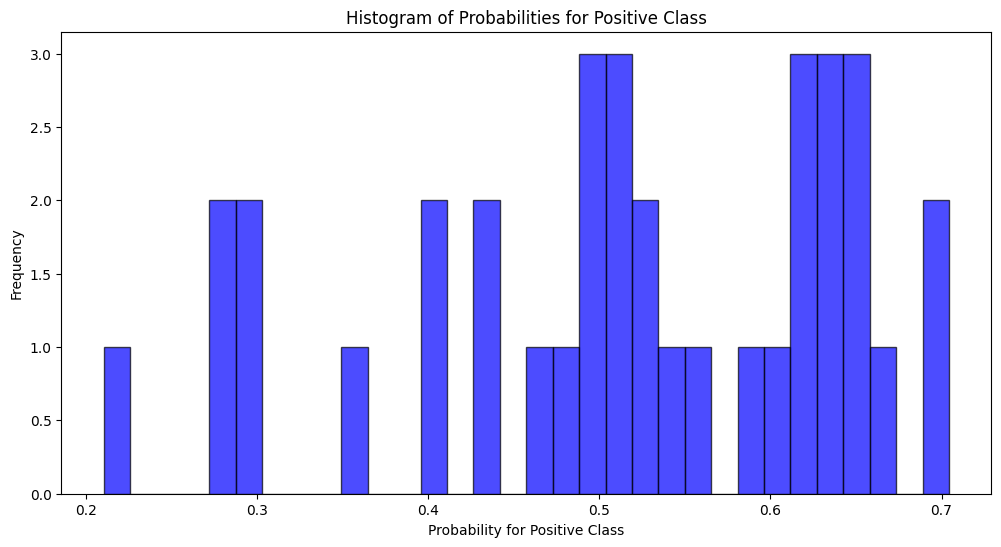

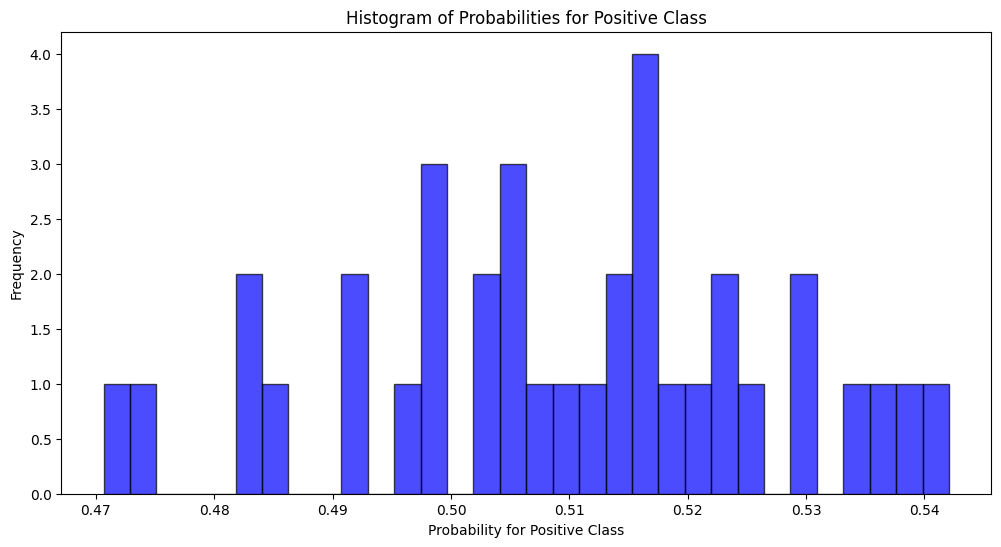

In [15]:
def plot_histograms(model, num_bins):
  positive_probabilities = []

  model.eval()

  with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        probabilities = torch.sigmoid(outputs)

        positive_probabilities.extend(probabilities[y_batch == 1].cpu().numpy().flatten())

  plt.figure(figsize=(12, 6))
  plt.hist(positive_probabilities, bins=num_bins, color='blue', alpha=0.7, edgecolor='black')
  plt.xlabel('Probability for Positive Class')
  plt.ylabel('Frequency')
  plt.title('Histogram of Probabilities for Positive Class')

  # plt.grid(True)
  plt.show()

plot_histograms(model0, 32)
plot_histograms(model1, 32)
plot_histograms(model2, 32)

The first model (BCELogitsLoss Function) will most of the time give the output 0, because the probabilities for the positive labels are far away from the threshold of 0.5. The second model (BCELogitsLoss with pos_weight) had the best F1 score and we can see that the probabilities for the positive labels are most of them above the 0.5 threshold, which results in correct answers. The third model (FocalLoss) presents similar issues with the first model, however they are less dramatic and most probabilities are near the threshold of 0.5, some of them below.

In [16]:
def validate_model(model, sigmoid_threshold):
  model.eval()

  val_predictions = []
  val_labels = []
  val_probabilities = []

  with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(X_batch)
      probabilities = torch.sigmoid(outputs)
      predictions = (probabilities > sigmoid_threshold).float()

      val_predictions.extend(predictions.cpu().numpy())
      val_labels.extend(y_batch.cpu().numpy())
      val_probabilities.extend(probabilities.cpu().numpy())

  return val_predictions, val_labels, val_probabilities


def get_model_probabilities(model):
  model.eval()

  val_labels = []
  val_probabilities = []

  with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(X_batch)
      probabilities = torch.sigmoid(outputs)

      val_labels.extend(y_batch.cpu().numpy())
      val_probabilities.extend(probabilities.cpu().numpy())

  return val_labels, val_probabilities

In [17]:
def find_best_sigmoid_threshold(model, left, right, step):
  best_f1_score = 0.0
  best_sigmoid_threshold = 0.5

  f1_scores = []
  sigmoid_thresholds = []

  for sigmoid_threshold in np.arange(left, right, step):
    val_predictions, val_labels, _ = validate_model(model, sigmoid_threshold)
    precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary', zero_division=0)
    if f1_score > best_f1_score:
      best_f1_score = f1_score
      best_sigmoid_threshold = sigmoid_threshold
    f1_scores.append(f1_score)
    sigmoid_thresholds.append(sigmoid_threshold)

  return best_f1_score, best_sigmoid_threshold, f1_scores, sigmoid_thresholds

In [18]:
def plot_sigmoid_thresholds(model):
  best_f1_score, best_sigmoid_threshold, f1_scores, sigmoid_thresholds = find_best_sigmoid_threshold(model, 0.25, 0.75, 0.01)

  plt.figure(figsize=(12, 6))
  plt.plot(sigmoid_thresholds, f1_scores, marker='o', linestyle='-', color='blue')
  plt.xlabel('Sigmoid Threshold')
  plt.ylabel('F1 Score')
  plt.title('F1 Score Evolution')
  plt.show()

  return best_f1_score, best_sigmoid_threshold

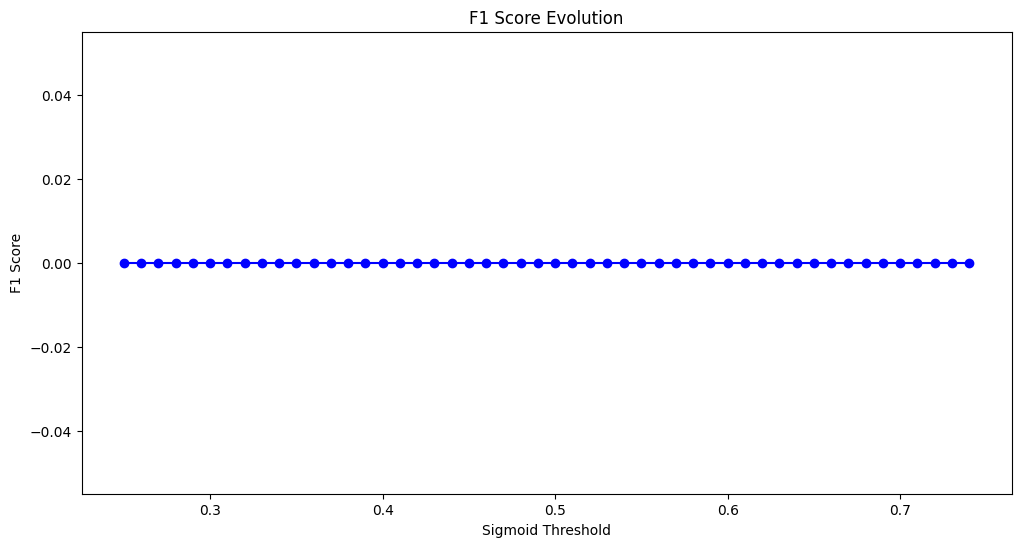

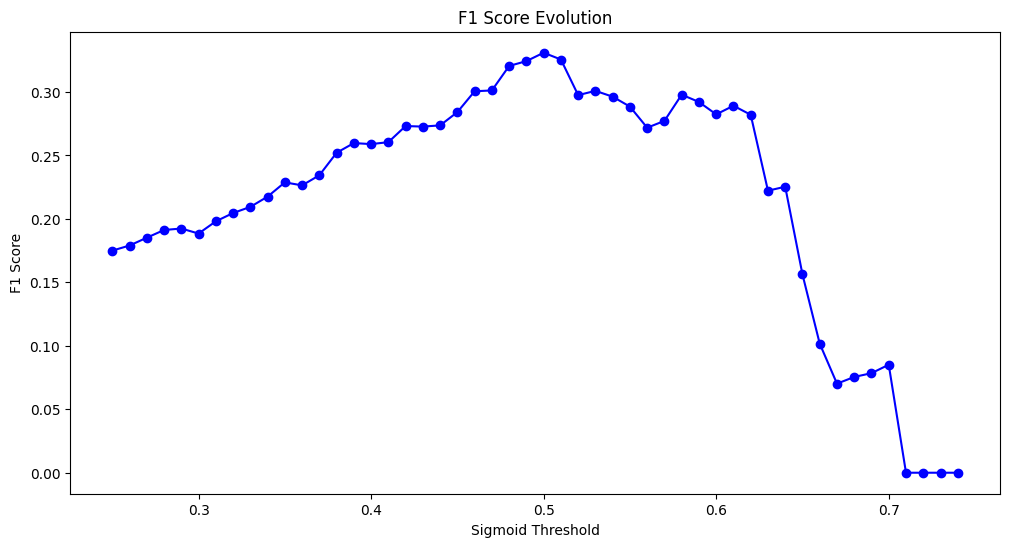

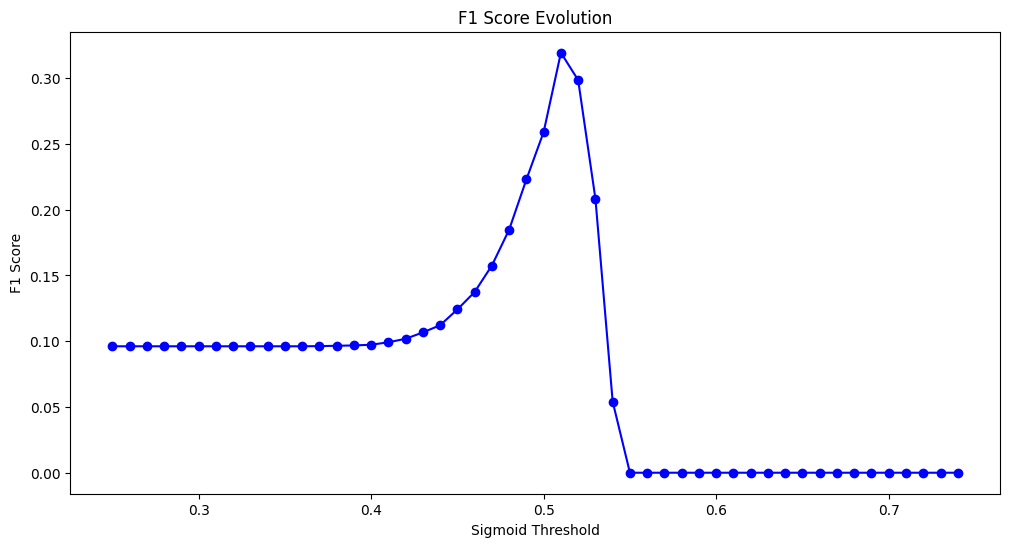

In [19]:
_, best_sigmoid_threshold0 = plot_sigmoid_thresholds(model0)
_, best_sigmoid_threshold1 = plot_sigmoid_thresholds(model1)
_, best_sigmoid_threshold2 = plot_sigmoid_thresholds(model2)

The model which used the Focal Loss function seems to be the most sensitive to changes in the threshold's value. The model was able to go from an F1 score of around 0.3 to 0 using a very small increase in the threshold (around 0.05).

In [20]:
def plot_precision_recall_curve(model):
  val_labels, val_probabilities = get_model_probabilities(model)
  precision, recall, _ = precision_recall_curve(val_labels, val_probabilities)

  area_under_curve = auc(recall, precision)

  plt.figure(figsize=(12, 6))
  plt.plot(recall, precision, marker='o', linestyle='-', color='blue')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.show()

  print('Area under the Curve:', area_under_curve)

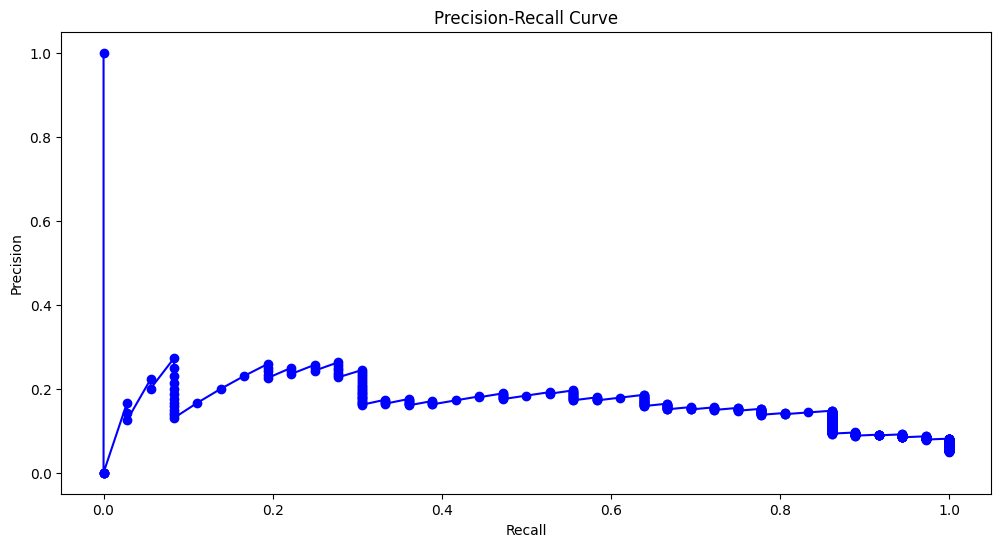

Area under the Curve: 0.1672478332032431


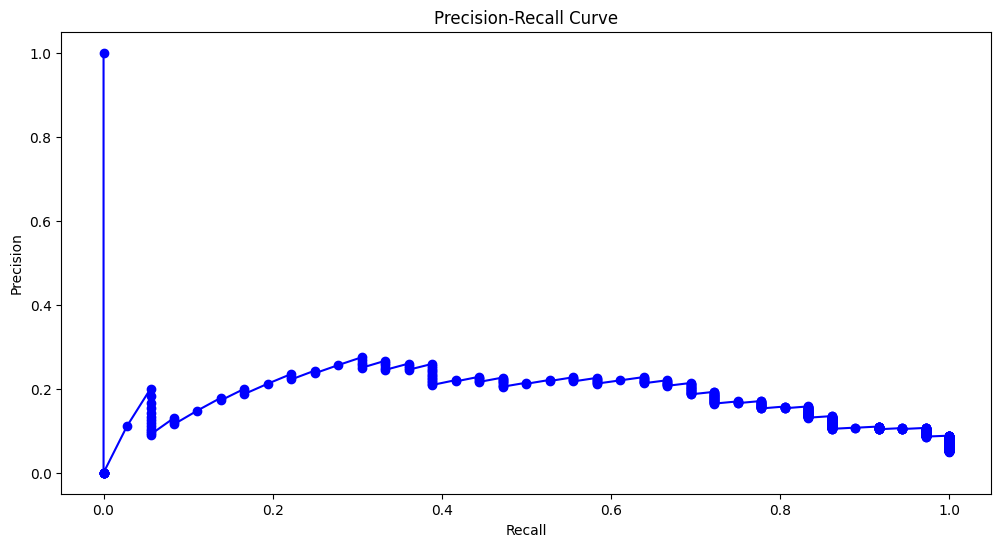

Area under the Curve: 0.18365485790311237


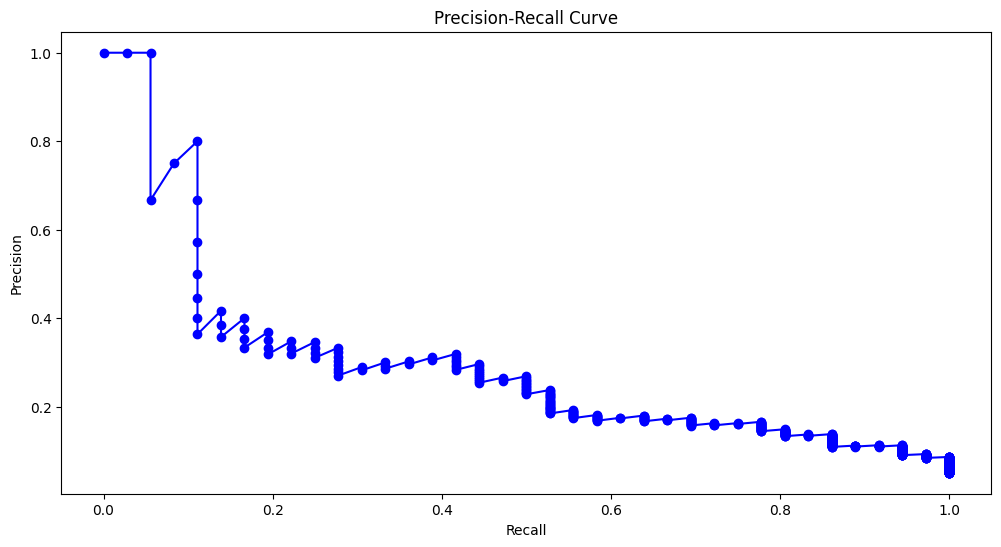

Area under the Curve: 0.29391046101477164


In [21]:
plot_precision_recall_curve(model0)
plot_precision_recall_curve(model1)
plot_precision_recall_curve(model2)

In [22]:
def test_performance(model, sigmoid_threshold):
  model.eval()

  correct_predictions = 0
  total_predictions = 0

  test_predictions = []
  test_labels = []

  with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(X_batch)
      predictions = (torch.sigmoid(outputs) > sigmoid_threshold).float()

      correct_predictions += (predictions.squeeze(dim=1) == y_batch).sum().item()
      total_predictions += y_batch.size(0)

      test_predictions.extend(predictions.cpu().numpy())
      test_labels.extend(y_batch.cpu().numpy())

  test_accuracy = correct_predictions / total_predictions
  precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary', zero_division=0)

  return test_accuracy, precision, recall, f1_score

In [27]:
test_accuracy0, precision0, recall0, f1_score0 = test_performance(model0, 0.5)
test_accuracy1, precision1, recall1, f1_score1 = test_performance(model1, 0.5)
test_accuracy2, precision2, recall2, f1_score2 = test_performance(model2, 0.5)

test_accuracy0_best_threshold, precision0_best_threshold, recall0_best_threshold, f1_score0_best_threshold = test_performance(model0, best_sigmoid_threshold0)
test_accuracy1_best_threshold, precision1_best_threshold, recall1_best_threshold, f1_score1_best_threshold = test_performance(model1, best_sigmoid_threshold1)
test_accuracy2_best_threshold, precision2_best_threshold, recall2_best_threshold, f1_score2_best_threshold = test_performance(model2, best_sigmoid_threshold2)

test_df = pd.DataFrame({
    'Model': ['BCEWithLogitsLoss', 'BCEWithLogitsLoss PosWeight', 'FocalLoss', 'BCEWithLogitsLoss (Best Threshold)', 'BCEWithLogitsLoss PosWeight (Best Threshold)', 'FocalLoss (Best Threshold)'],
    'Test Accuracy': [test_accuracy0, test_accuracy1, test_accuracy2, test_accuracy0_best_threshold, test_accuracy1_best_threshold, test_accuracy2_best_threshold],
    'Precision': [precision0, precision1, precision2, precision0_best_threshold, precision1_best_threshold, precision2_best_threshold],
    'Recall': [recall0, recall1, recall2, recall0_best_threshold, recall1_best_threshold, recall2_best_threshold],
    'F1 Score': [f1_score0, f1_score1, f1_score2, f1_score0_best_threshold, f1_score1_best_threshold, f1_score2_best_threshold]
})

test_df = test_df.style.highlight_max(subset=['Test Accuracy', 'Precision', 'Recall', 'F1 Score'], axis=0, color='green')

test_df

,Model,Test Accuracy,Precision,Recall,F1 Score
0,BCEWithLogitsLoss,0.931373,0.000000,0.000000,0.000000
1,BCEWithLogitsLoss PosWeight,0.836134,0.185185,0.408163,0.254777
2,FocalLoss,0.782913,0.164557,0.530612,0.251208
3,BCEWithLogitsLoss (Best Threshold),0.931373,0.000000,0.000000,0.000000
4,BCEWithLogitsLoss PosWeight (Best Threshold),0.836134,0.185185,0.408163,0.254777
5,FocalLoss (Best Threshold),0.861345,0.228261,0.428571,0.297872
